## Aquisition
The Wikipedia traffic data must first be retrieved from the Legacy and Pageviews API endpoints. The Legacy API provides data for desktop and mobile traffic from December 2007 to July 2016. The Pageviews API provides data for desktop, mobile web, and mobile app traffic from July 2015 and on.

This section creates 5 JSON files corresponding to each API call. The calls specify user traffic when possible.

In [1]:
import json
import requests

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

headers = {
    'User-Agent': 'https://github.com/rileywaters',
    'From': 'rdwaters@uw.edu'
}

In [3]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

#### File 1: Desktop Legacy

In [4]:
desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2016080100"
                    }
desktop_monthly_legacy = api_call(endpoint_legacy, desktop_params_legacy)

with open('legacy_desktop-site_200801-201608.json', 'w', encoding='utf-8') as f:
    json.dump(desktop_monthly_legacy, f, ensure_ascii=False, indent=4)

    

#### FIle 2: Mobile Legacy

In [5]:
mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2016080100"
                    }
mobile_monthly_legacy = api_call(endpoint_legacy, mobile_params_legacy)

with open('legacy_mobile-site_200801-201608.json', 'w', encoding='utf-8') as f:
    json.dump(mobile_monthly_legacy, f, ensure_ascii=False, indent=4)

#### File 3: Desktop PageViews

In [6]:
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019090100'}

desktop_monthly_pageviews = api_call(endpoint_pageviews, desktop_params_pageviews)

with open('pageviews_desktop-site_201507-201909.json', 'w', encoding='utf-8') as f:
    json.dump(desktop_monthly_pageviews, f, ensure_ascii=False, indent=4)

#### File 4: Mobile App PageViews

In [7]:
mobile_app_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019090100'
                        }

mobile_app_monthly_pageviews = api_call(endpoint_pageviews, mobile_app_params_pageviews)

with open('pageviews_mobile-app_201507-201909.json', 'w', encoding='utf-8') as f:
    json.dump(mobile_app_monthly_pageviews, f, ensure_ascii=False, indent=4)

#### File 5: Mobile Web PageViews

In [8]:
mobile_web_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2014100100",
                    "end" : '2019090100'
                        }

mobile_web_monthly_pageviews = api_call(endpoint_pageviews, mobile_web_params_pageviews)

with open('pageviews_mobile-web_201507-201909.json', 'w', encoding='utf-8') as f:
    json.dump(mobile_web_monthly_pageviews, f, ensure_ascii=False, indent=4)

## Processing
The data files must now be processed into Pandas dataframes. The pageview mobile views are combined and the timestamps are separated into year and month. NA values are filled with 0.

This step produces a csv file called en-wikipedia_traffic_200712-201809.csv

In [9]:
import pandas as pd

In [10]:
# Read all the json files into pandas dataframes
df_legacy_mobile = pd.DataFrame(json.load(open('legacy_mobile-site_200801-201608.json', 'r'))['items'])
df_legacy_desktop = pd.DataFrame(json.load(open('legacy_desktop-site_200801-201608.json', 'r'))['items'])

df_pageviews_mobile_web = pd.DataFrame(json.load(open('pageviews_mobile-web_201507-201909.json', 'r'))['items'])
df_pageviews_mobile_app = pd.DataFrame(json.load(open('pageviews_mobile-app_201507-201909.json', 'r'))['items'])
df_pageviews_desktop = pd.DataFrame(json.load(open('pageviews_desktop-site_201507-201909.json', 'r'))['items'])

In [11]:
# For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
df_pageviews_mobile_web['views'] = df_pageviews_mobile_web['views'] + df_pageviews_mobile_app['views']

# rename the columns of each view count
df_pageviews_mobile = df_pageviews_mobile_web[['timestamp', 'views']].rename(columns={'views': 'pageview_mobile_views'})

df_pageviews_desktop = df_pageviews_desktop[['timestamp', 'views']].rename(columns={'views': 'pageview_desktop_views'})

df_legacy_mobile = df_legacy_mobile[['timestamp', 'count']].rename(columns={'count': 'pagecount_mobile_views'})

df_legacy_desktop = df_legacy_desktop[['timestamp', 'count']].rename(columns={'count': 'pagecount_desktop_views'})

# merge the dataframes
df_pageview_merge = df_pageviews_mobile.merge(df_pageviews_desktop, how='outer', on='timestamp')
df_legacy_merge = df_legacy_mobile.merge(df_legacy_desktop, how='outer', on='timestamp')
df_all = df_pageview_merge.merge(df_legacy_merge, how='outer', on='timestamp')

# fill na with 0
df_all = df_all.fillna(0)



In [12]:
# Split the timestamp into year and month
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'], format='%Y%m%d%H')

# Make a total views column for each API
df_all['pagecount_all_views'] = df_all['pagecount_mobile_views'] + df_all['pagecount_desktop_views']
df_all['pageview_all_views'] = df_all['pageview_mobile_views'] + df_all['pageview_desktop_views']

df_all['month'] = df_all['timestamp'].dt.month
df_all['year'] = df_all['timestamp'].dt.year
df_all.drop(['timestamp'], axis=1)

# save to csv
df_all.to_csv('en-wikipedia_traffic_200712-201809.csv', index=False)

## Analysis
Using the csv file, the counts are plotted as a time series. Dotted lines are used to indicate that the data is from the legacy system. Solid lines indicate that the data is from the newer API

In [13]:
from datetime import datetime

In [14]:
# Read the csv and construct the timestamp
df_all = pd.read_csv('en-wikipedia_traffic_200712-201809.csv', sep=',')

df_all['timestamp'] = pd.to_datetime(df_all['year'].astype(str)  + df_all['month'].astype(str), format='%Y%m')
df_all = df_all.sort_values(by='timestamp')

df_all.head()

,timestamp,pageview_mobile_views,pageview_desktop_views,pagecount_mobile_views,pagecount_desktop_views,pagecount_all_views,pageview_all_views,month,year
59,2008-01-01,0.0,0.0,0.0,4.930903e+09,4.930903e+09,0.0,1,2008
60,2008-02-01,0.0,0.0,0.0,4.818394e+09,4.818394e+09,0.0,2,2008
61,2008-03-01,0.0,0.0,0.0,4.955406e+09,4.955406e+09,0.0,3,2008
62,2008-04-01,0.0,0.0,0.0,5.159162e+09,5.159162e+09,0.0,4,2008
63,2008-05-01,0.0,0.0,0.0,5.584691e+09,5.584691e+09,0.0,5,2008


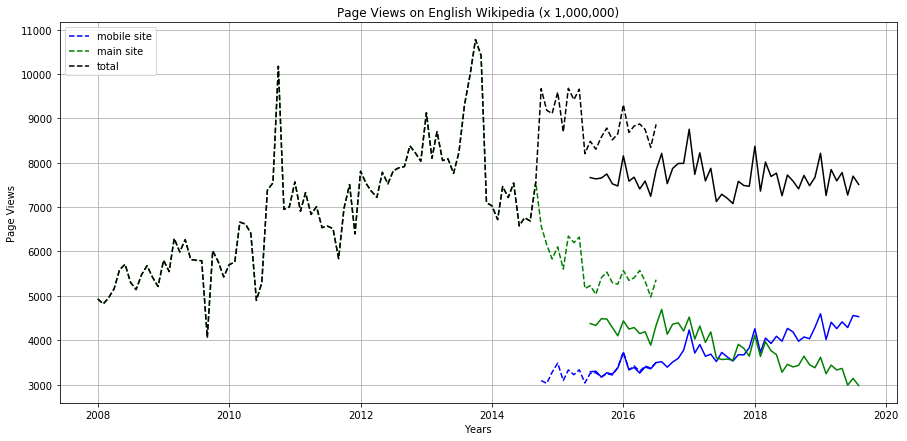

In [16]:
from matplotlib import pyplot as plt
from matplotlib import dates as pltdates

# Create the plot
formatter = pltdates.DateFormatter('%Y')
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot_date(df_all['timestamp'], df_all['pageview_mobile_views'].where(df_all['pageview_mobile_views']>0)/1e6, fmt='b-', label='_nolegend_')
ax.plot_date(df_all['timestamp'], df_all['pageview_desktop_views'].where(df_all['pageview_desktop_views']>0)/1e6, fmt='g-', label='_nolegend_')
ax.plot_date(df_all['timestamp'], df_all['pagecount_mobile_views'].where(df_all['pagecount_mobile_views']>0)/1e6, fmt='b--', label = 'mobile site')
ax.plot_date(df_all['timestamp'], df_all['pagecount_desktop_views'].where(df_all['pagecount_desktop_views']>0)/1e6, fmt='g--', label='main site')

ax.plot_date(df_all['timestamp'], df_all['pagecount_all_views'].where(df_all['pagecount_all_views']>0)/1e6, fmt='k--', label='total')
ax.plot_date(df_all['timestamp'], df_all['pageview_all_views'].where(df_all['pageview_all_views']>0)/1e6, fmt='k-', label='_nolegend_')

ax.xaxis.set_major_formatter(formatter)
ax.title.set_text('Page Views on English Wikipedia (x 1,000,000)')
ax.set_ylabel('Page Views')
ax.set_xlabel('Years')
ax.grid(True)
ax.legend(loc='upper left')
plt.show()

# Save the plot as png
fig.savefig('final_graph.png')